# Well-being - Nutrition

In this notebook, bla bla bla

## Import modules

In [27]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE

from statsmodels.stats import diagnostic

from utils import calculate_nutripoints

sns.set_theme('notebook')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [10]:
year_grocery = pd.read_csv("data/year_osward_grocery.csv")
display(year_grocery.head())

wellbeing_data = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Data")
display(wellbeing_data.head())

wellbeing_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Scores", header=[0, 1])
display(wellbeing_scores.head())

wellbeing_final_scores = pd.read_excel(
    "data/london-ward-well-being-probability-scores.xls", sheet_name="Ranked", header=[3], usecols="B:C")
display(wellbeing_final_scores.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,449.535137,32.5,166.4,300.0,500.0,1500.0,771.349423,3.716832,125.960833,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,413.130263,32.5,150.0,300.0,500.0,1500.0,626.395178,5.164174,110.664114,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,407.100472,32.5,160.0,300.0,500.0,1200.0,545.890959,2.710677,121.990710,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,384.173858,30.0,150.0,250.0,454.0,1500.0,591.837557,4.968373,122.245578,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,356.882607,30.0,140.0,250.0,450.0,1000.0,465.284180,3.880963,109.959688,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362


,Old Ward Code,New ward code,Ward,Borough,Life Expectancy 2005-2009,Life Expectancy 2006-2010,Life Expectancy 2007-11,Life Expectancy 2008-12,Life Expectancy 2009-13,Childhood Obesity 2009,...,"Homes with access to open space & nature, and % greenspace - 2009","Homes with access to open space & nature, and % greenspace - 2010","Homes with access to open space & nature, and % greenspace - 2011","Homes with access to open space & nature, and % greenspace - 2012","Homes with access to open space & nature, and % greenspace - 2013","Subjective well-being average score, 2011/12 and 2012/13","Subjective well-being average score, 2011/12 and 2012/13.1","Subjective well-being average score, 2011/12 and 2012/13.2","Subjective well-being average score, 2011/12 and 2012/13.3","Subjective well-being average score, 2013"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00AA,E09000001,City of London,City of London,84.3294,83.730426,83.704458,84.482365,86.393685,22.22,...,-6.47875,-6.478752,-6.478752,-6.478752,-6.478752,7.64033,7.640332,7.640332,7.640332,7.655963
2,00ABFX,E05000026,Abbey,Barking and Dagenham,82.0761,82.482712,82.132476,81.122613,81.998428,21.7009,...,-0.889538,-0.889538,-0.889538,-0.889538,-0.889538,7.89796,7.897959,7.897959,7.897959,7.789197
3,00ABFY,E05000027,Alibon,Barking and Dagenham,77.8284,78.266936,78.301335,78.145305,78.989687,25.974,...,-1.79097,-1.790968,-1.790968,-1.790968,-1.790968,7.35884,7.358842,7.358842,7.358842,7.553030
4,00ABFZ,E05000028,Becontree,Barking and Dagenham,78.4307,78.914120,78.721642,79.019303,79.229604,22.449,...,-5.46967,-5.469666,-5.469666,-5.469666,-5.469666,7.60912,7.609123,7.609123,7.609123,7.551141


Old Ward Code New ward code       Ward name               Borough  \
  Old Ward Code New ward code       Ward name               Borough   
0          00AA     E09000001  City of London        City of London   
1        00ABFX     E05000026           Abbey  Barking and Dagenham   
2        00ABFY     E05000027          Alibon  Barking and Dagenham   
3        00ABFZ     E05000028       Becontree  Barking and Dagenham   
4        00ABGA     E05000029  Chadwell Heath  Barking and Dagenham   

  Life Expectancy                                              \
             2009       2010       2011       2012       2013   
0         18.7787  14.927723  13.653698  16.026485  23.661861   
1         9.10692   9.583198   6.867900   1.417979   4.251859   
2        -9.12595  -8.474883  -9.670047 -11.527627  -9.035117   
3        -6.54069  -5.702701  -7.855704  -7.727404  -7.975613   
4       -0.285993  -2.129908  -0.888760  -3.151067  -1.211477   

  Childhood Obesity  ...  \
               2009  ...   
0          -7.17432  ...   
1          -6.11698  ...   
2          -14.8205  ...   
3           -7.6407  ...   
4          -10.3826  ...   

  Homes with access to open space & nature, and % greenspace            \
                                                        2009      2010   
0                                           -9.52981         -9.529812   
1                                           -1.30845         -1.308451   
2                                           -2.63439         -2.634394   
3                                           -8.04551         -8.045513   
4                                            2.90909          2.909091   

                                Subjective well-being average score  \
       2011      2012      2013                                2009   
0 -9.529812 -9.529812 -9.529812                                   0   
1 -1.308451 -1.308451 -1.308451                             8.09781   
2 -2.634394 -2.634394 -2.634394                            -8.84788   
3 -8.045513 -8.045513 -8.045513                           -0.980979   
4  2.909091  2.909091  2.909091                             -16.729   

                                              
        2010       2011       2012      2013  
0   0.000000   0.000000   0.000000  0.000000  
1   8.097813   8.097813   8.097813  6.118185  
2  -8.847876  -8.847876  -8.847876 -4.726708  
3  -0.980979  -0.980979  -0.980979 -4.813479  
4 -16.729023 -16.729023 -16.729023 -4.813479  

[5 rows x 64 columns]

,Index Score 2013,Ward
0,17.217884,Knightsbridge and Belgravia
1,13.741583,Campden
2,11.572839,West Wickham
3,11.566019,South Twickenham
4,11.435223,East Sheen


## Preprocessing

### Filter data

We consider only 80% of the areas, the one with the highest representativeness norm 

In [11]:
PERCENTAGE_SPLIT_REPRESENTATIVENESS = 0.8
N = len(year_grocery)

year_grocery = year_grocery.nlargest(
    int(PERCENTAGE_SPLIT_REPRESENTATIVENESS * N), 'representativeness_norm')

### Compute nutripoints

We add a column with the computed nutripoints, assessing the quality of the average product of each area

In [12]:
year_grocery["nutripoints"] = year_grocery.apply(calculate_nutripoints, axis=1)
year_grocery["nutripoints"].describe()

count    510.000000
mean       9.237255
std        1.469929
min        0.500000
25%        8.500000
50%        9.000000
75%       10.000000
max       14.500000
Name: nutripoints, dtype: float64

In [13]:
display(year_grocery.head())

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km,nutripoints
570,E05011117,382.039628,40.0,175.0,300.0,500.0,1000.0,363.202381,0.465398,105.990925,...,11911.0,6099.0,5812.0,1558.0,9552.0,801.0,34.867937,1.35,8822.962963,8.5
565,E05011112,398.825948,40.0,180.0,320.0,500.0,1000.0,397.149657,0.492467,107.602664,...,16365.0,8103.0,8262.0,2997.0,12218.0,1150.0,33.235625,1.30,12588.461538,8.0
246,E05000336,397.066289,40.0,180.0,300.0,500.0,1000.0,414.783419,0.608474,122.609742,...,11959.0,5764.0,6195.0,2625.0,7194.0,2140.0,40.250941,3.32,3602.108434,10.0
438,E05000605,416.199096,40.5,182.0,325.0,500.0,1200.0,506.239533,0.700727,107.997869,...,13599.0,7196.0,6403.0,2630.0,9919.0,1050.0,34.684389,1.31,10380.916031,9.0
162,E05000252,374.792470,40.0,173.7,300.0,500.0,1000.0,354.119901,0.563867,99.371843,...,12013.0,5828.0,6185.0,1709.0,8813.0,1491.0,37.502289,0.89,13497.752809,8.5


### Filter wellbeing data

We filter the columns giving the information about the last year of the dataset, 2013 and we remove NaN values

In [14]:
wellbeing_scores = wellbeing_scores.loc[:, (slice(
    None), [2013, "New ward code", "Ward name", "Borough"])].dropna(how="all")
wellbeing_scores = wellbeing_scores.droplevel(1, axis=1)
display(wellbeing_scores.head())

,New ward code,Ward name,Borough,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score
0,E09000001,City of London,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000
1,E05000026,Abbey,Barking and Dagenham,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185
2,E05000027,Alibon,Barking and Dagenham,-9.035117,-12.944834,-20.398595,-15.084810,-9.218119,-3.905882,-10.941296,-11.507206,-17.164782,-4.501940,-2.634394,-4.726708
3,E05000028,Becontree,Barking and Dagenham,-7.975613,-18.487966,-7.354425,-14.275467,-13.060348,1.890929,-12.819252,-10.803760,-16.413721,-6.460879,-8.045513,-4.813479
4,E05000029,Chadwell Heath,Barking and Dagenham,-1.211477,-19.346426,-11.983294,-10.292302,-6.060588,-31.284887,-6.503490,-14.903977,-12.907861,-10.826177,2.909091,-4.813479


### Merge datasets

In [15]:
#Merging the two well being datasets according to the ward name
wellbeing_scores = pd.merge(
    left=wellbeing_scores, right=wellbeing_final_scores, left_on='Ward name', right_on="Ward")
wellbeing_scores = wellbeing_scores.drop("Ward", axis=1)
display(wellbeing_scores.head())

,New ward code,Ward name,Borough,Life Expectancy,Childhood Obesity,Incapacity Benefit rate,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
0,E09000001,City of London,City of London,23.661861,-19.399351,15.136349,8.610513,17.205862,5.606699,10.348951,11.827561,8.094587,29.202424,-9.529812,0.000000,8.397137
1,E05000026,Abbey,Barking and Dagenham,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,5.158493
2,E05000026,Abbey,Barking and Dagenham,4.251859,-8.272848,3.953790,-11.228402,-18.441350,-15.314186,-4.528620,-7.570297,-9.420035,15.818063,-1.308451,6.118185,-3.828524
3,E05000455,Abbey,Merton,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,5.158493
4,E05000455,Abbey,Merton,1.954939,6.874674,14.659226,9.631054,1.193650,2.594187,8.906345,10.408799,3.096512,9.678513,-1.195187,-5.900801,-3.828524


In [16]:
list_column = ["area_id", "energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb",
               "energy_fibre", "energy_alcohol", "h_nutrients_calories", "nutripoints"]
year_grocery = year_grocery.loc[:,
                                year_grocery.columns.isin(list(list_column))]
display(year_grocery.head())

#wellbeing_data = wellbeing_data.filter(
    #regex=r'(2013$|-13$|New ward code|Ward$|Borough)')
#display(wellbeing_data.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints
570,E05011117,78.438016,30.789383,34.635855,22.770981,65.237562,3.026622,1.892084,171.365266,1.608028,8.5
565,E05011112,78.516170,30.681996,36.415653,22.396706,68.789239,2.984949,1.558974,174.246039,1.589399,8.0
246,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,10.0
438,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,9.0
162,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,8.5


In [17]:
#wellbeing_data.dropna(how='all', axis=0)

In [18]:
#Merging the 2 datasets of interest: year grocery and wellbeing scores according to the ward name
wellbeing_grocery = pd.merge(
    left=year_grocery, right=wellbeing_scores, left_on='area_id', right_on="New ward code")
wellbeing_grocery = wellbeing_grocery.drop("New ward code", axis=1)
display(wellbeing_grocery.head())

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
0,E05000336,78.864004,32.414378,38.719523,21.433875,71.160848,2.994211,1.741239,176.194176,1.582813,...,7.382849,5.663200,1.732487,9.104353,14.362369,6.829642,-12.410936,5.496664,0.097080,4.798106
1,E05000605,84.561946,33.918637,36.141050,22.015479,69.832483,3.067818,1.697021,181.174746,1.575484,...,-6.415999,-17.140935,6.149262,5.553690,2.833274,2.724538,12.165452,-4.355219,4.064134,0.440499
2,E05000252,80.542785,31.635739,33.648475,22.141379,61.322242,3.149138,1.689631,168.845175,1.598050,...,2.223858,5.477066,9.517488,18.843265,0.391431,4.402315,16.172939,-14.255212,9.646084,4.269507
3,E05000427,77.568453,30.521094,35.742617,22.364672,66.992603,2.985766,1.760651,171.672145,1.600125,...,-11.114732,-13.774964,8.269988,4.929764,7.254350,-10.552446,18.059347,-13.621024,1.783860,-2.659193
4,E05000595,82.975277,33.302798,37.707033,21.336347,71.447922,2.947414,1.372449,180.079409,1.559561,...,-5.951363,-6.697261,2.509921,-5.728663,-1.420357,3.504061,4.092038,9.694047,4.064134,-0.489500


In [19]:
wellbeing_grocery_columns = wellbeing_grocery.columns.values.tolist()
wellbeing_grocery.isnull().any() #checking for any null values in the new dataset

area_id                                                       False
energy_fat                                                    False
energy_saturate                                               False
energy_sugar                                                  False
energy_protein                                                False
energy_carb                                                   False
energy_fibre                                                  False
energy_alcohol                                                False
energy_tot                                                    False
h_nutrients_calories                                          False
nutripoints                                                   False
Ward name                                                     False
Borough                                                       False
Life Expectancy                                               False
Childhood Obesity                               

In [20]:
wellbeing_grocery.describe() #exploring data 

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,80.774453,31.908111,40.271732,21.063283,72.074066,3.029884,1.682096,178.623782,1.572242,9.288647,...,-2.559664,-5.637407,1.664926,4.140902,0.491332,-1.570287,0.086403,-0.640641,-0.945463,-0.411776
std,2.815440,1.371391,3.241331,0.911611,5.328385,0.120886,0.350880,6.931980,0.024423,1.377576,...,9.729277,9.203556,8.501475,9.749412,10.420337,9.295638,9.509300,9.927869,9.739047,5.121256
min,67.111854,26.283257,33.119113,17.596480,58.462154,2.750710,0.715793,156.104396,1.465237,5.000000,...,-54.658671,-47.737871,-44.322159,-24.274349,-33.740795,-27.284950,-16.720060,-32.738196,-22.995993,-13.819509
25%,79.111206,31.039763,38.087105,20.605970,68.294016,2.947507,1.438488,174.137633,1.556396,8.500000,...,-8.459775,-10.406264,-1.714313,-3.010887,-5.986843,-7.827685,-7.096940,-7.672257,-8.974028,-4.143008
50%,80.526276,31.767310,39.797617,21.262472,72.080308,3.022995,1.671868,178.673453,1.573805,9.000000,...,-0.437333,-4.053333,3.876656,3.653406,1.326355,-2.041617,-2.668173,-0.621308,-0.364830,-0.199689
75%,82.248204,32.643980,42.239147,21.684800,75.886539,3.102445,1.887892,182.731751,1.590084,10.500000,...,5.161143,0.686241,7.416967,10.526070,7.913508,5.851170,5.702022,6.257372,4.148313,3.109617
max,92.440804,38.690892,48.719140,23.005837,84.618879,3.617668,3.147601,197.674474,1.641436,14.500000,...,12.594709,11.838724,11.357859,31.306345,23.799230,18.603360,30.159917,26.930630,22.945127,11.435223


In [21]:
COLUMNS_SCORES = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average Capped GCSE and Equivalent Point Score Per Pupil',
    'Unauthorised Absence in All Schools (%)',
    'Dependent children in out-of-work families',
    'Public Transport Accessibility',
    'Homes with access to open space & nature, and % greenspace',
    'Subjective well-being average score',
    'Index Score 2013'
]

COLUMNS_GROCERY = [
    'energy_fat',
    'energy_saturate',
    'energy_sugar',
    'energy_protein',
    'energy_carb',
    'energy_fibre',
    'energy_alcohol',
    'energy_tot',
    'h_nutrients_calories',
    'nutripoints'
]

COLUMNS = COLUMNS_GROCERY + COLUMNS_SCORES

wellbeing_grocery_analysis = wellbeing_grocery[COLUMNS].copy()

In [22]:
#standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler()
wellbeing_grocery_analysis[wellbeing_grocery_analysis.columns] = scaler.fit_transform(wellbeing_grocery_analysis
                                                                                      [wellbeing_grocery_analysis.columns])
wellbeing_grocery_analysis.describe()

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,...,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,2.402802e-16,3.775831e-16,-1.819264e-15,-1.484588e-15,5.663746e-16,-5.835375e-16,-1.351576e-16,7.894919e-16,6.933799e-15,-1.287215e-16,...,-1.287215e-17,2.145359e-17,-8.581434e-18,-1.287215e-17,4.290717e-18,-1.287215e-17,8.581434e-18,1.823555e-17,-4.290717e-17,-1.287215e-17
std,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,...,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-4.858612e+00,-4.106531e+00,-2.209362e+00,-3.807545e+00,-2.557694e+00,-2.312199e+00,-2.757274e+00,-3.252553e+00,-4.386729e+00,-3.116950e+00,...,-5.361349e+00,-4.579904e+00,-5.415851e+00,-2.918087e+00,-3.289101e+00,-2.769662e+00,-1.769510e+00,-3.236988e+00,-2.266876e+00,-2.621223e+00
25%,-5.914738e-01,-6.339534e-01,-6.748060e-01,-5.022616e-01,-7.102759e-01,-6.822733e-01,-6.951179e-01,-6.479501e-01,-6.496369e-01,-5.731818e-01,...,-6.071623e-01,-5.187806e-01,-3.979695e-01,-7.344486e-01,-6.224379e-01,-6.739686e-01,-7.563159e-01,-7.091274e-01,-8.253661e-01,-7.294591e-01
50%,-8.825514e-02,-1.027941e-01,-1.464485e-01,2.187660e-01,1.172799e-03,-5.706061e-02,-2.918486e-02,7.174067e-03,6.406804e-02,-2.097863e-01,...,2.184025e-01,1.723237e-01,2.604732e-01,-5.006307e-02,8.023090e-02,-5.076569e-02,-2.900224e-01,1.949633e-03,5.969118e-02,4.146312e-02
75%,5.240866e-01,5.372358e-01,6.077119e-01,6.826036e-01,7.163681e-01,6.009698e-01,5.872242e-01,5.933283e-01,7.314173e-01,8.804002e-01,...,7.945244e-01,6.879187e-01,6.774120e-01,6.557210e-01,7.131397e-01,7.993466e-01,5.912542e-01,6.956537e-01,5.236590e-01,6.884352e-01
max,4.148718e+00,4.951899e+00,2.609308e+00,2.133481e+00,2.357185e+00,4.868205e+00,4.181711e+00,2.751558e+00,2.836632e+00,3.787564e+00,...,1.559490e+00,1.901143e+00,1.141527e+00,2.789739e+00,2.239476e+00,2.172853e+00,3.166364e+00,2.780519e+00,2.456041e+00,2.316098e+00


## Exploratory Data Analysis

Text(0.5, 0.98, 'Boxplot for variables')

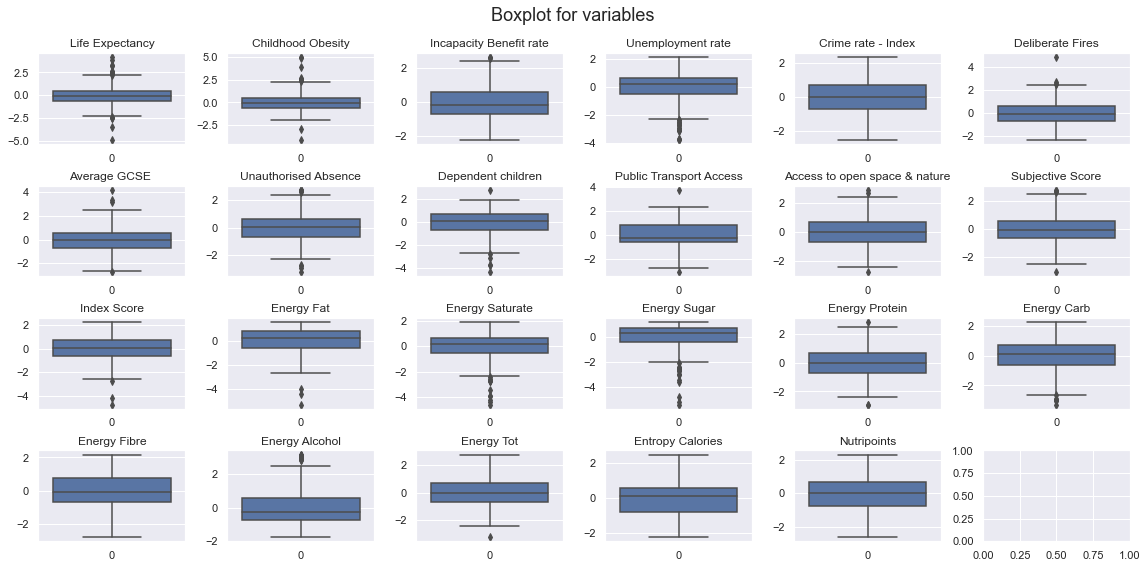

In [96]:
COLUMNS_SHORT = [
    'Life Expectancy',
    'Childhood Obesity',
    'Incapacity Benefit rate',
    'Unemployment rate',
    'Crime rate - Index',
    'Deliberate Fires',
    'Average GCSE ',
    'Unauthorised Absence',
    'Dependent children',
    'Public Transport Access',
    'Access to open space & nature',
    'Subjective Score',
    'Index Score',
    'Energy Fat',
    'Energy Saturate',
    'Energy Sugar',
    'Energy Protein',
    'Energy Carb',
    'Energy Fibre',
    'Energy Alcohol',
    'Energy Tot',
    'Entropy Calories',
    'Nutripoints'
]


#Explanatory data analysis: visually show the distribution of the data
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i/6), i % 6]

    sns.boxplot(data=wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    # TODO: make names of columns shorter to fit plot
    sbplt.set_title(COLUMNS_SHORT[i], loc='center', wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Boxplot for variables', fontsize=18)

These boxplots give us a general view of the distribution of each variables. Since we would like to cluster nutrient data for specific areas and predict nutrional habits according to well-being characteristics, it is important to observe difference between areas for the different features. Here, the nutrional as well as the well being features seems to take various values between the different wards. Moreover, some outliers can sometimes be seen, for example for the energy saturate and the crime rate. 


/Users/camillegollety/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/camillegollety/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/camillegollety/opt/anaconda3/envs/ada/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

Text(0.5, 0.98, 'Distplot for each column')

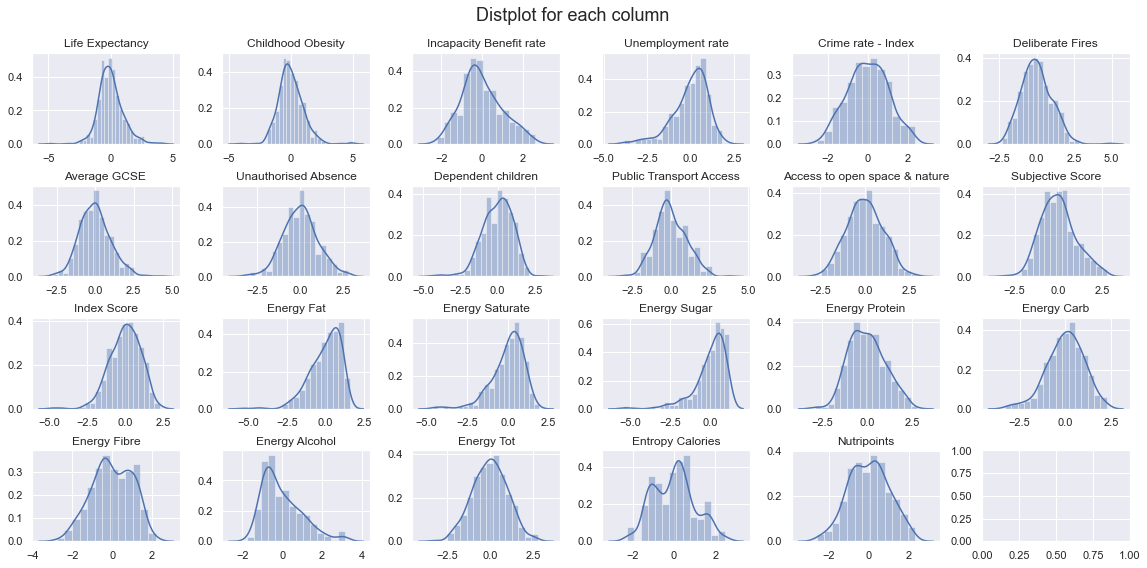

In [100]:
#Explanatory data analysis: distribution of the different variables by counting the number of observations 
fig, ax = plt.subplots(4, 6, figsize=(16, 8), sharey=False)

for i in range(len(COLUMNS)):
    sbplt = ax[int(i/6), i % 6]

    sns.distplot(wellbeing_grocery_analysis.iloc[:, i], ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('')
    sbplt.set_title(COLUMNS_SHORT[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle('Distplot for each column', fontsize=18)

It seems that certain variables follow a normal distribution, let's check: 

In [28]:
#checking for any normal distribution 
for i in range(len(COLUMNS)):
    print(wellbeing_grocery_analysis.columns[i], diagnostic.kstest_normal(wellbeing_grocery_analysis.iloc[:, i], dist = 'norm'))

energy_fat (0.07903216865905405, 0.0009999999999998899)
energy_saturate (0.05326903182093623, 0.007581189826131957)
energy_sugar (0.07251996494284862, 0.0009999999999998899)
energy_protein (0.08876799457406159, 0.0009999999999998899)
energy_carb (0.026851481287560097, 0.6903939704884319)
energy_fibre (0.038606909345865525, 0.16346729546429065)
energy_alcohol (0.05190847073443838, 0.009968381379691995)
energy_tot (0.03103558001885176, 0.4594223025890827)
h_nutrients_calories (0.05360270195456229, 0.0069957442091933535)
nutripoints (0.12404662721690057, 0.0009999999999998899)
Life Expectancy (0.03202904042931304, 0.412173758424854)
Childhood Obesity (0.0554713286478391, 0.004272239753128864)
Incapacity Benefit rate (0.03829769415806922, 0.17191349500448455)
Unemployment rate (0.09308541477110721, 0.0009999999999998899)
Crime rate - Index (0.10222109516633626, 0.0009999999999998899)
Deliberate Fires (0.12711248129388664, 0.0009999999999998899)
Average Capped GCSE and Equivalent Point Scor

The second value returned by the function is the p-value. When the p_value < 0.05 -> we can reject the null hypothesis that the data comes from a normal distribution!
Here, we observe that:  
-Carbs  
-Fibres  
-Energy_total  
-Life Expectancy  
-Incapacity Benefit rate  
-Unauthorised Absence in All Schools  
-Homes with access to open space & nature, and % greenspace  
-Index Score 2013   
have a p-value > 0.05. 
Therefore, the null hypothesis is not rejected and we can say that those variables follow a normal distribution 

<AxesSubplot:>

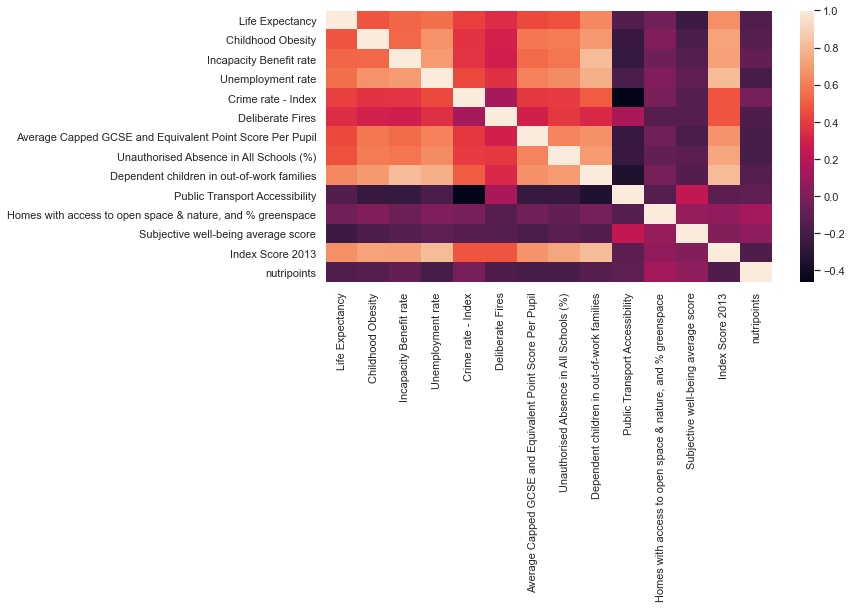

In [30]:
#Computing and plotting the correlation between the well-being scores and nutriponts 
fig = plt.figure(figsize=(10, 5))

sns.heatmap(
    wellbeing_grocery_analysis[COLUMNS_SCORES + ['nutripoints']].corr())

In [33]:
#Computing the correlation between the differnet variables from the dataset according to the spearman method
correlation = wellbeing_grocery_analysis.corr(method="spearman")
display(correlation.head())

,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,energy_alcohol,energy_tot,h_nutrients_calories,nutripoints,...,Unemployment rate,Crime rate - Index,Deliberate Fires,Average Capped GCSE and Equivalent Point Score Per Pupil,Unauthorised Absence in All Schools (%),Dependent children in out-of-work families,Public Transport Accessibility,"Homes with access to open space & nature, and % greenspace",Subjective well-being average score,Index Score 2013
energy_fat,1.000000,0.794008,0.518320,-0.051129,0.528766,-0.022809,-0.306844,0.760485,-0.554516,0.484302,...,-0.170388,0.010652,-0.176290,-0.083693,-0.039851,-0.012980,-0.253005,0.212674,0.167257,-0.051765
energy_saturate,0.794008,1.000000,0.420225,-0.172299,0.325855,-0.061581,-0.169905,0.506666,-0.414911,0.590893,...,0.051839,0.176281,0.012804,0.053995,0.140953,0.165477,-0.276443,0.182293,0.008602,0.139416
energy_sugar,0.518320,0.420225,1.000000,-0.517745,0.843177,-0.299513,-0.397929,0.780870,-0.777506,0.436790,...,-0.099329,0.242386,-0.315661,-0.033822,0.069130,0.007639,-0.492036,0.021304,0.051887,-0.080296
energy_protein,-0.051129,-0.172299,-0.517745,1.000000,-0.316860,0.374254,0.302556,-0.145463,0.551938,-0.315371,...,0.077650,-0.142165,0.094958,0.012193,-0.020728,-0.046501,0.119329,0.112256,0.060965,0.041988
energy_carb,0.528766,0.325855,0.843177,-0.316860,1.000000,-0.355920,-0.585464,0.932636,-0.860796,0.232162,...,-0.314781,0.126398,-0.417559,-0.170743,-0.085563,-0.141283,-0.505008,-0.006541,0.041767,-0.271345


<ipython-input-101-f04e000f9200>:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


Text(0.5, 0.98, 'Sperman Correlation')

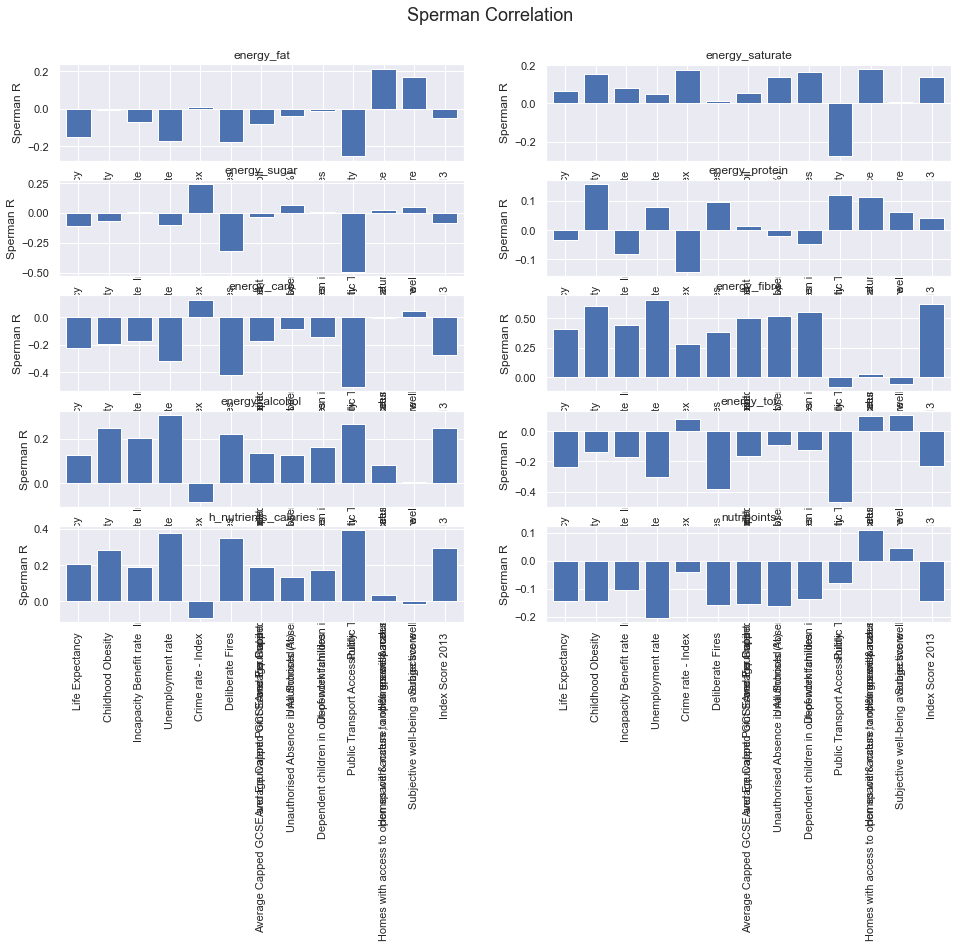

In [101]:
fig, ax = plt.subplots(5, 2, figsize=(16, 10), sharey=False)

for i in range(len(COLUMNS_GROCERY)):
    sbplt = ax[int(i/2), i % 2]
    
    correlation[COLUMNS_GROCERY[i]][COLUMNS_SCORES].plot.bar(x=None, y=None, width=0.8, legend=None, ax=sbplt)
    sbplt.set_xlabel('')
    sbplt.set_ylabel('Sperman R')
    sbplt.set_title(wellbeing_grocery_analysis.columns[i], wrap=True)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

fig.suptitle("Sperman Correlation", fontsize=18)

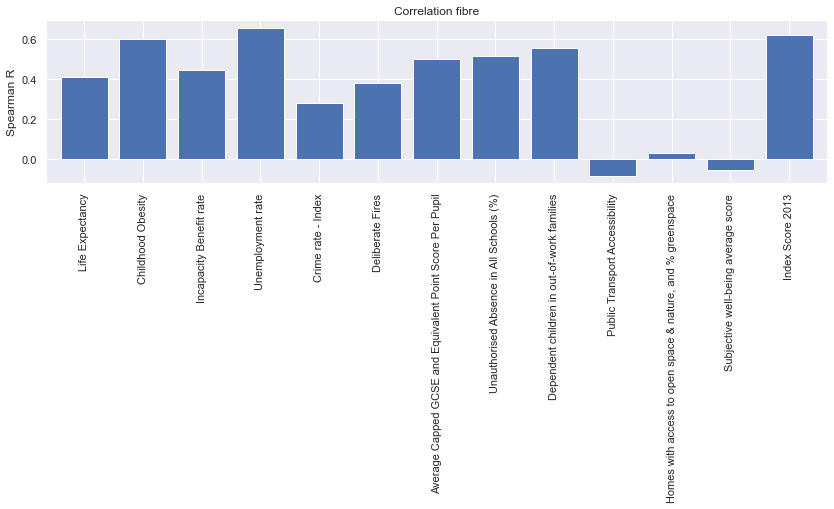

In [34]:
# TODO: put the five following barplots in a single subplots

plt.figure(figsize=(14, 3))

correlation["energy_fibre"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation fibre")
plt.show()

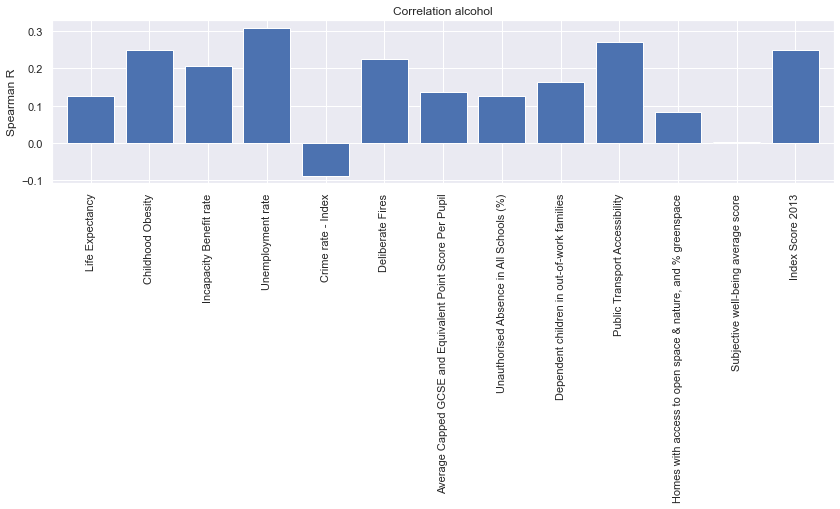

In [64]:
plt.figure(figsize=(14, 3))

correlation["energy_alcohol"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation alcohol")
plt.show()

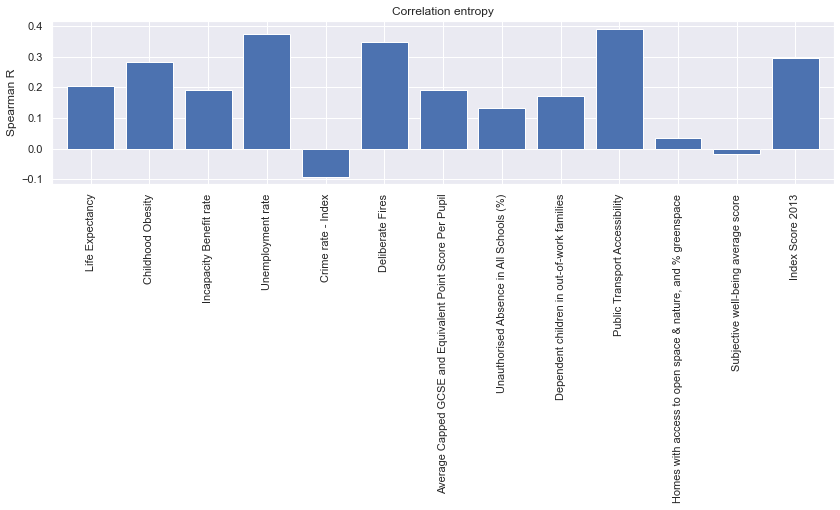

In [65]:
plt.figure(figsize=(14, 3))

correlation["h_nutrients_calories"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation entropy")
plt.show()

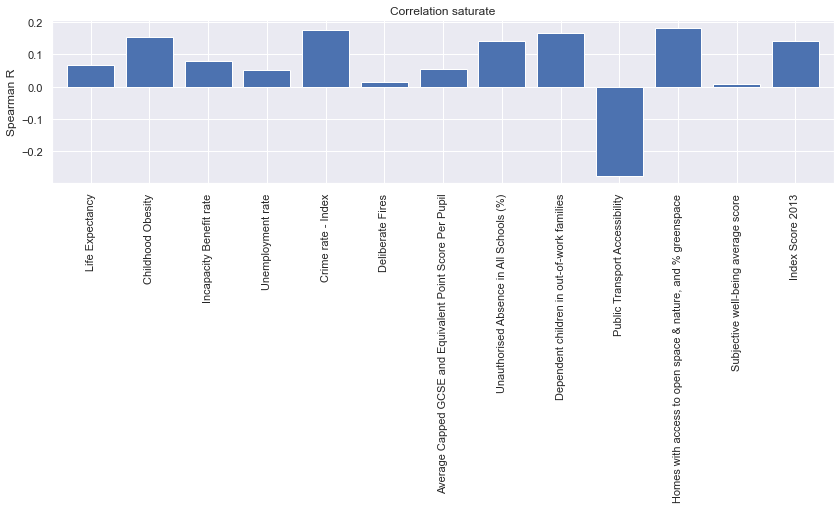

In [66]:
plt.figure(figsize=(14, 3))

correlation["energy_saturate"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation saturate")
plt.show()

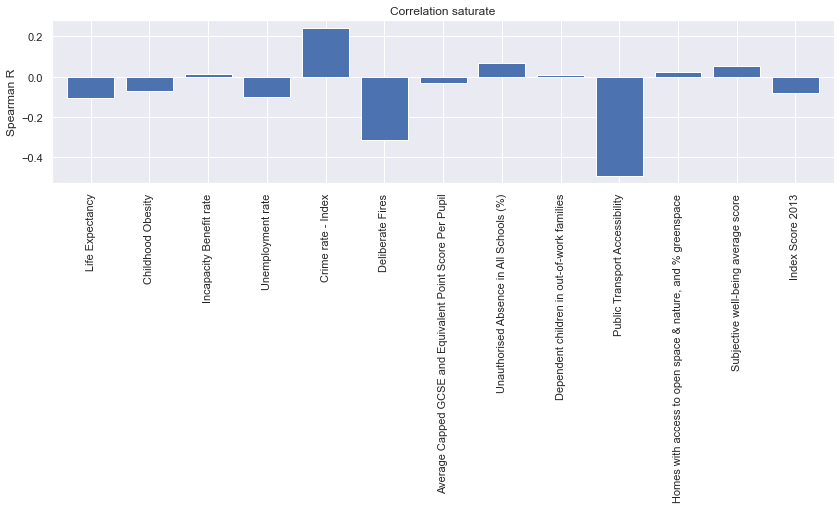

In [67]:
plt.figure(figsize=(14, 3))

correlation["energy_sugar"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation saturate")
plt.show()

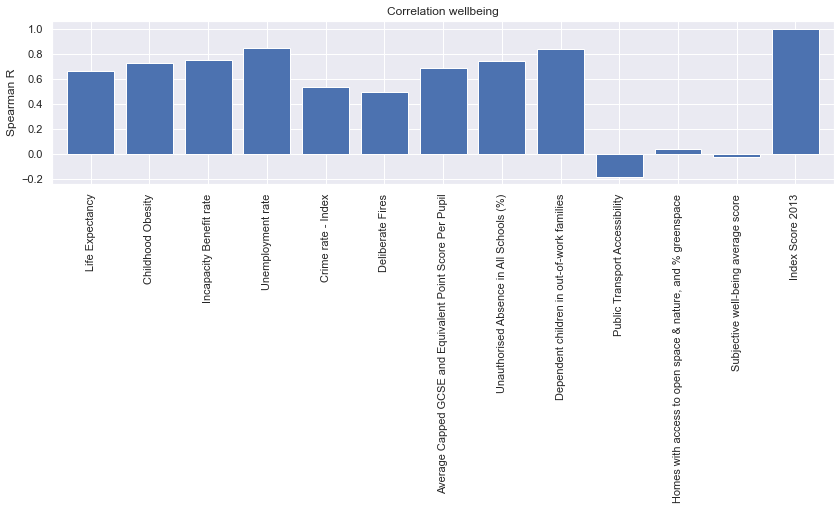

In [68]:
plt.figure(figsize=(14, 3))

correlation["Index Score 2013"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation wellbeing")
plt.show()

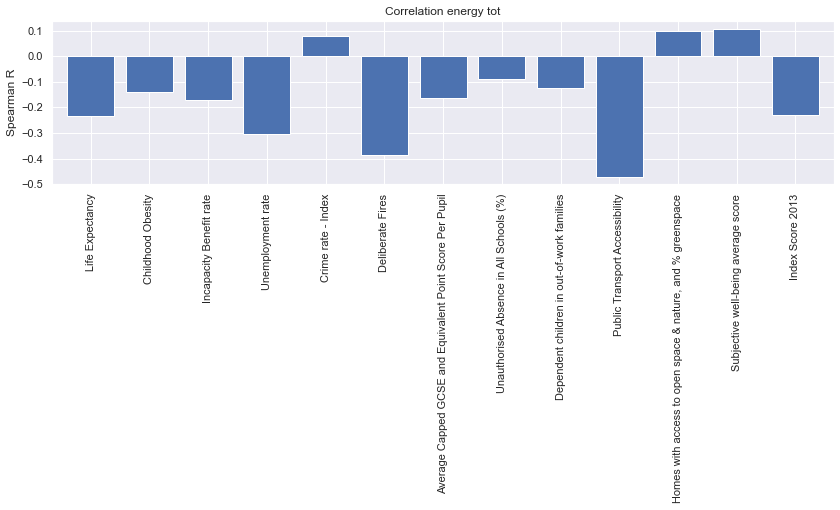

In [69]:
plt.figure(figsize=(14, 3))

correlation["energy_tot"][COLUMNS_SCORES].plot.bar(
    x=None, y=None, width=0.8, legend=None)

plt.ylabel("Spearman R")
plt.title("Correlation energy tot")
plt.show()

In [71]:
reg_features = 'Q("Life Expectancy") + Q("Incapacity Benefit rate") + Q("Unemployment rate") + Q("Crime rate - Index") \
+ Q("Childhood Obesity") + Q("Homes with access to open space & nature, and % greenspace")'

mod = smf.ols(formula='h_nutrients_calories ~ ' +
              reg_features, data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     h_nutrients_calories   R-squared:                       0.245
Model:                              OLS   Adj. R-squared:                  0.234
Method:                   Least Squares   F-statistic:                     21.98
Date:                  Fri, 11 Dec 2020   Prob (F-statistic):           2.02e-22
Time:                          11:28:39   Log-Likelihood:                -529.33
No. Observations:                   414   AIC:                             1073.
Df Residuals:                       407   BIC:                             1101.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [72]:
mod = smf.ols(formula='energy_fibre ~ ' + reg_features,
              data=wellbeing_grocery_analysis)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           energy_fibre   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     52.48
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           9.22e-48
Time:                        11:28:39   Log-Likelihood:                -468.83
No. Observations:                 414   AIC:                             951.7
Df Residuals:                     407   BIC:                             979.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [73]:
wellbeing_scores_columns = wellbeing_scores.columns.values.tolist()
print(wellbeing_scores_columns)

['New ward code', 'Ward name', 'Borough', 'Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate', 'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires', 'Average Capped GCSE and Equivalent Point Score Per Pupil', 'Unauthorised Absence in All Schools (%)', 'Dependent children in out-of-work families', 'Public Transport Accessibility', 'Homes with access to open space & nature, and % greenspace', 'Subjective well-being average score', 'Index Score 2013']


In [75]:
wellbeing_scores_analysis = wellbeing_scores[COLUMNS_SCORES]\
    .dropna().copy()
wellbeing_scores_reduced_pca = PCA(n_components=2).fit(
    wellbeing_scores_analysis).transform(wellbeing_scores_analysis)

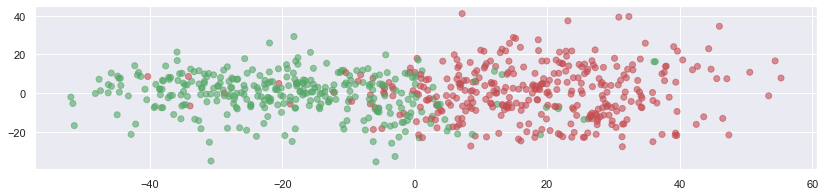

In [76]:
labels = wellbeing_scores_analysis.apply(
    lambda row: "g" if row['Index Score 2013'] >= 0 else "r", axis=1)
# Plot the data reduced in 2d space with PCA
plt.figure(figsize=(14, 3))
plt.scatter(wellbeing_scores_reduced_pca[:, 0],
            wellbeing_scores_reduced_pca[:, 1], c=labels, alpha=0.6)

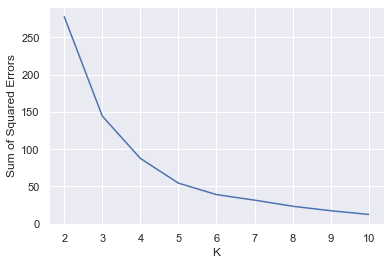

In [77]:
columns_kmeans_health = ['h_nutrients_calories', 'energy_alcohol']
columns_kmeans = ['nutripoints']
wellbeing_grocery_kmeans = wellbeing_grocery[columns_kmeans].copy()


def plot_sse(X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(X)
        sse.append({"k": k, "sse": kmeans.inertia_})
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")


plot_sse(wellbeing_grocery_kmeans)

Text(0, 0.5, 'Silhouette score')

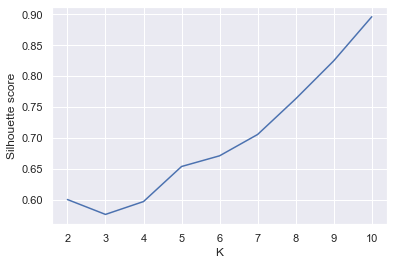

In [78]:
#######    silhouette scores to choose k    #########
silhouettes = []
for k in range(2, 11):  # Try multiple k
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(
        wellbeing_grocery_kmeans)
    # Get the Silhouette score
    score = silhouette_score(wellbeing_grocery_kmeans, labels)
    silhouettes.append({"k": k, "score": score})

silhouettes = pd.DataFrame(silhouettes)  # Convert to dataframe

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

<AxesSubplot:xlabel='nutripoints'>

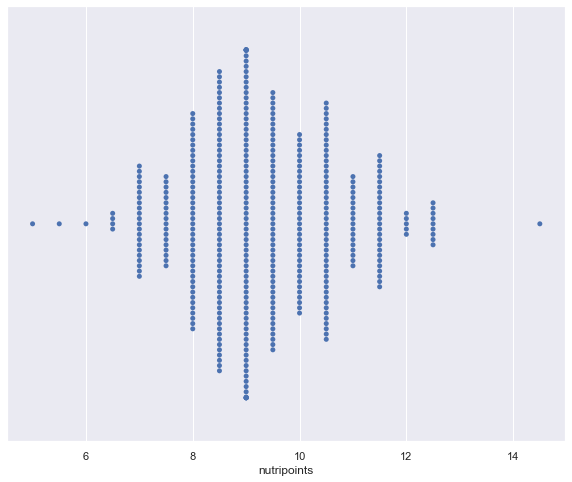

In [80]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=True, sharex=True)

# Cluster the data with the current number of clusters
kmean = KMeans(n_clusters=5, random_state=42).fit(wellbeing_grocery_kmeans)

# Plot the data by using the labels as color
wellbeing_grocery_kmeans['label'] = kmean.labels_
sns.swarmplot(data=wellbeing_grocery_kmeans, x='nutripoints',
              ax=axs, hue=wellbeing_grocery_kmeans.label)
# Plot the centroids
# for c in kmean.cluster_centers_:
#axs.scatter(c[0], c[1], marker="+", color="red")

In [81]:
wellbeing_grocery["nutri_label"] = kmean.labels_
wellbeing_grocery.groupby("nutri_label")["nutripoints"].min()

nutri_label
0     9.0
1    10.0
2     8.0
3    11.5
4     5.0
Name: nutripoints, dtype: float64

## Predictive Models

In [82]:
X = wellbeing_grocery[COLUMNS_SCORES]
y = wellbeing_grocery["nutripoints"]

In [83]:
## Linear regression ##

# create the model
lin_reg = LinearRegression()

# train it
lin_reg.fit(X, y)

LinearRegression()

In [84]:
for f in range(len(COLUMNS_SCORES)):
    print(
        "{0} * {1} + ".format(lin_reg.coef_[f], COLUMNS_SCORES[f]))
print(lin_reg.intercept_)

-0.013931128683031703 * Life Expectancy + 
-0.003276913147818127 * Childhood Obesity + 
0.01572972041225762 * Incapacity Benefit rate + 
-0.026275053555409034 * Unemployment rate + 
0.006243399042761861 * Crime rate - Index + 
-0.006090825647984133 * Deliberate Fires + 
-0.017665110103486138 * Average Capped GCSE and Equivalent Point Score Per Pupil + 
-0.015032884839344294 * Unauthorised Absence in All Schools (%) + 
-0.0005120442209429155 * Dependent children in out-of-work families + 
-0.021045723604638068 * Public Transport Accessibility + 
0.011164877276630285 * Homes with access to open space & nature, and % greenspace + 
0.0033622262723829884 * Subjective well-being average score + 
0.03663868640595468 * Index Score 2013 + 
9.402665704447262


In [85]:
reg2_features = 'Q("Life Expectancy")\
                + Q("Childhood Obesity")\
                + Q("Incapacity Benefit rate")\
                + Q("Unemployment rate")\
                + Q("Crime rate - Index")\
                + Q("Deliberate Fires")\
                + Q("Average Capped GCSE and Equivalent Point Score Per Pupil")\
                + Q("Unauthorised Absence in All Schools (%)")\
                + Q("Dependent children in out-of-work families")\
                + Q("Public Transport Accessibility")\
                + Q("Homes with access to open space & nature, and % greenspace")\
                + Q("Subjective well-being average score")\
                + Q("Index Score 2013")'

mod = smf.ols(formula='nutripoints ~ ' + reg2_features,
              data=wellbeing_grocery_analysis)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            nutripoints   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.372
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           6.15e-05
Time:                        11:30:00   Log-Likelihood:                -565.91
No. Observations:                 414   AIC:                             1160.
Df Residuals:                     400   BIC:                             1216.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### Train Gradient Boosting Regressor

In [86]:
## Gradient Boosting Regression ##
gradboost = GradientBoostingRegressor()

In [87]:
# Select appropriate features using recursive feature elimination

selector = RFE(gradboost, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
print(X.columns)
print(selector.ranking_)

Index(['Life Expectancy', 'Childhood Obesity', 'Incapacity Benefit rate',
       'Unemployment rate', 'Crime rate - Index', 'Deliberate Fires',
       'Average Capped GCSE and Equivalent Point Score Per Pupil',
       'Unauthorised Absence in All Schools (%)',
       'Dependent children in out-of-work families',
       'Public Transport Accessibility',
       'Homes with access to open space & nature, and % greenspace',
       'Subjective well-being average score', 'Index Score 2013'],
      dtype='object')
[1 7 4 3 5 8 1 6 1 1 2 1 9]


In [88]:
predicted_y = cross_val_predict(gradboost, X, y, cv=5)

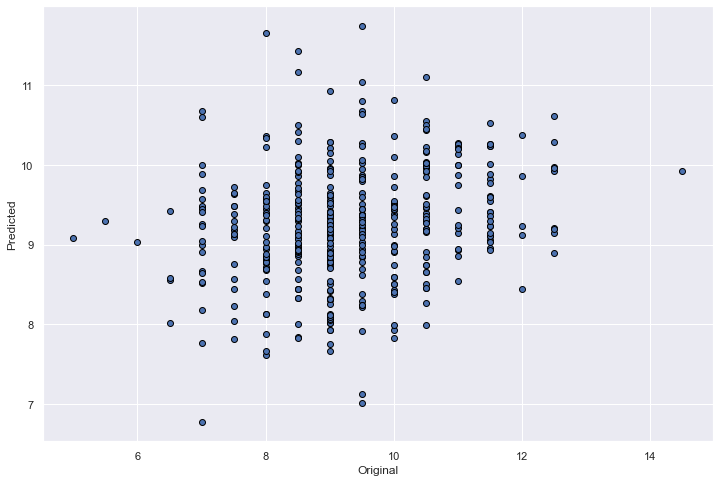

In [89]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted_y, edgecolors=(0, 0, 0))
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')
plt.show()

In [90]:
r2 = r2_score(y, predicted_y)
mse = mean_squared_error(y, predicted_y)

print(r2, mse)

-0.04953816187028259 1.9869142655452896


## Conclusions

According to our results, ...